In [2]:
%tensorflow_version 2.x
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import glob
import os
import copy
import random as rnd
import datetime
mpl.rcParams['figure.figsize'] = (6, 4)
mpl.rcParams['axes.grid'] = False

TensorFlow is already loaded. Please restart the runtime to change versions.


In [3]:
###### hyper_Parameters ######
data_set_num = 9
start_from_market = 100
plt.figure(figsize=(10,6))
test_split = 0.2
future_prediction = 1
corr_w = 40
w = 30

<Figure size 720x432 with 0 Axes>

In [4]:
# uploading the data from github into colab's working space
!wget https://github.com/srmt99/stock-market/blob/master/data/markets.npy?raw=true
!wget https://github.com/srmt99/stock-market/blob/master/data/stocks_1.npy?raw=true
!wget https://github.com/srmt99/stock-market/blob/master/data/stocks_2.npy?raw=true

stocks = []
for i in np.load("stocks_1.npy?raw=true",allow_pickle=True):
    stocks.append(i)
for i in np.load("stocks_2.npy?raw=true",allow_pickle=True):
    stocks.append(i)
stocks = np.array(stocks)
markets = np.load("markets.npy?raw=true",allow_pickle=True)
                  
# extracting minimum market length
min_market_len = len(markets[0])
for i in markets[1:]:
  if len(i)<min_market_len:
    min_market_len = len(i)

# making all markets of the same length
for i in range(len(markets)):
  while len(markets[i])>min_market_len:
    markets[i] = np.delete(markets[i],0,0)

for i in range(len(stocks)):
  while len(stocks[i])>min_market_len:
    stocks[i] = np.delete(stocks[i],0,0)

markets = np.stack(markets,0)

--2020-03-15 11:16:23--  https://github.com/srmt99/stock-market/blob/master/data/markets.npy?raw=true
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/srmt99/stock-market/raw/master/data/markets.npy [following]
--2020-03-15 11:16:24--  https://github.com/srmt99/stock-market/raw/master/data/markets.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/srmt99/stock-market/master/data/markets.npy [following]
--2020-03-15 11:16:24--  https://raw.githubusercontent.com/srmt99/stock-market/master/data/markets.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awai

287 47


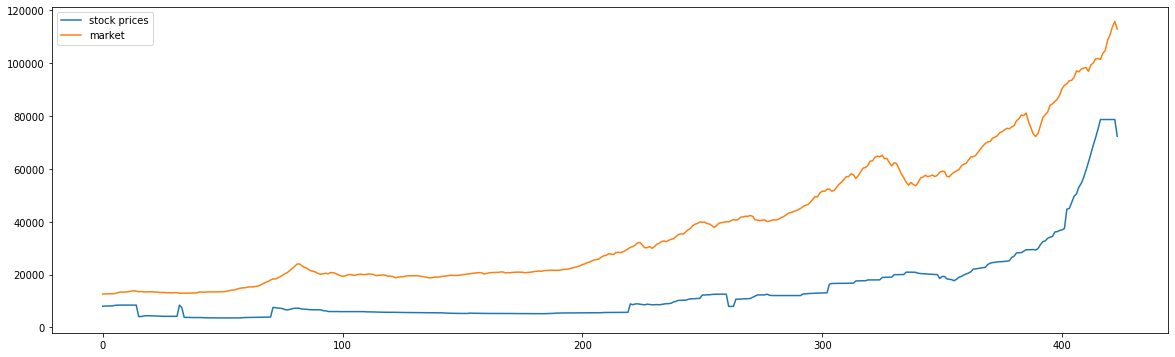

In [6]:
# ploting some random stock prices and markets
r1 = np.random.randint(len(stocks))
r2 = np.random.randint(len(markets))
print(r1,r2)
plt.figure(figsize=(20,6))
plt.plot(stocks[r1][:,1],label="stock prices")
plt.plot(markets[r2][:,1],label="market")
plt.legend()
plt.show()

In [0]:
def turn_into_windows(input,kernel):
    """
    this function is used to make windows out of the input array and select a label for each window
    input array of shape: (len_input, num_features) is turned into windows of shape: (kernel,num_features)
    and a labels is selected for each window , which is a floating point number label is selected
    from the second features (arr[...,1]) which here is <CLOSE> price for the NEXT sample
    NOTE: every window and it's label is normilized together and the info for denormilizing it is stored in
    norm_info, which at this time is not needed therfore is commented.

    input: 2D array of (time_samples, features)
    kernel: window size

    returns: two np.arrays of shape: (len_input - kernel + 1, kernel, num_features) , (len_input - kernel + 1,)
    """
    data = []
    labels = []
    # norm_info = []
    # j = 0
    # j is for counting num(windows) , used for norm_info
    for i in range(kernel,len(input)-1):
        window = input[i-kernel:i+1,:]
        # norm_info.append([np.min(window,0),None])
        window = window - np.min(window,0)
        # norm_info[j][1] = np.max(window,0)
        window = window / np.max(window,0)
        data.append(window[:-1,:])
        labels.append(window[-1,1])
        # j+=1
    return np.array(data),np.array(labels).reshape(len(labels),1)

def turn_into_windows_multi(input,kernel):
  """
  this function is mush similar to the one above (turn_into_windows)
  yet this fucntion was created speceficaly for extracting 2d matrices from all markets as windows.
  meaning at each step, we make <num_markets> windows from all market <CLOSE> prices together, which
  will increase the speed of creating the records further.
  input is a 2d matrix of shape: (num_markets, len_markets) and is turned into 2d matrices
  of shape: (num_markets, kernel)
  NOTE: all of the data in each matrix of windows, is normilized. the info is stored in norm_info
  which is commented at the time being , since there is no use for it.

  input: 2d matrix of shape: (num_markets, time_samples)
  kernel: window size

  returns: a np.array of shape: (len_markets - kernel + 1, num_markets, kernel)
  """
  data = []
  norm_info = []
  # j = 0
  # j is for counting num(windows) , used for norm_info
  for i in range(kernel,input.shape[1]-1):
    window = input[:,i-kernel:i]
    # norm_info.append([np.min(window,1).reshape((len(window),1)),None])
    window = window - np.min(window,1).reshape((len(window),1))
    # norm_info[j][1] = np.max(window,1).reshape((len(window),1))
    window = window / np.max(window,1).reshape((len(window),1))
    data.append(window)
  return np.array(data)

def smooth(input):
    output = []
    output.append(input[0])
    output.append(np.mean([input[0],input[1]]))
    for i in range(2,len(input)-2):
        mean = np.mean([input[i-2],input[i-1],input[i],input[i+1],input[i+2]])
        output.append(mean)
    output.append(np.mean([input[len(input)-2],input[len(input)-1]]))
    output.append(input[len(input)-1])
    return output

In [10]:
"""
this part, creates the records and saves them as np.array into files
it itreates over stocks, one stock at a time, the stock is first turend into windows
of shape: (corr_w,) holding <CLOSE> price in a list of windows. these windows are used
to calculate the correlation with the coresponding market windows of shape: (num_mrkets,corr_w)
meaning the correalation of each stock window is calculataed against all markets at the same time
then, both the stock and markets are turned into windows of length <w> to be put into the records
togrther with the before calculated correlations.
"""
for count,stock in enumerate(stocks):
  records = []
  labels = []
  correlations = []
  x,y = turn_into_windows(stock,corr_w)
  for wc,window in enumerate(x[:,:,1]):
    corr = np.corrcoef(window,markets[: , min_market_len - len(x) - corr_w - 1 + wc : min_market_len - len(x) + wc -1 , 1])[1:,0]
    correlations.append( np.nan_to_num(corr) )
  correlations = np.array(correlations)
  x,y = turn_into_windows(stock,w)
  x2 = turn_into_windows_multi(markets[:,:,1],w)
  for wc in range(len(correlations),w,-1):
      record = np.zeros( (2*len(markets)+5,w) )
      record[:5,:] = np.transpose(x[wc + (len(x)-len(correlations)-1) ][:,1:]) # part 1
      record[5:5+len(markets)] = np.transpose(correlations[wc-w:wc]) # part 2
      record[5+len(markets):5+2*len(markets)] = x2[wc + (len(x2)-len(correlations)-1)] # part 3
      records.append(record)
      labels.append(y[wc + (len(x)-len(correlations)-1) ])
  np.save(f"records_{count}",np.array([records,labels]))
  print(f"{count}/{len(stocks)}")
print("__done__")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


0/572
1/572
2/572
3/572
4/572
5/572
6/572
7/572
8/572
9/572
10/572
11/572
12/572
13/572
14/572
15/572


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


16/572
17/572
18/572
19/572
20/572
21/572
22/572
23/572
24/572
25/572
26/572
27/572
28/572
29/572
30/572
31/572
32/572
33/572
34/572
35/572
36/572
37/572
38/572
39/572
40/572
41/572
42/572
43/572
44/572
45/572
46/572
47/572
48/572
49/572
50/572
51/572
52/572
53/572
54/572
55/572
56/572
57/572
58/572
59/572
60/572
61/572
62/572
63/572
64/572
65/572
66/572
67/572
68/572
69/572
70/572
71/572
72/572
73/572
74/572
75/572
76/572
77/572
78/572
79/572
80/572
81/572
82/572
83/572
84/572
85/572
86/572
87/572
88/572
89/572
90/572
91/572
92/572
93/572
94/572
95/572
96/572
97/572
98/572
99/572
100/572
101/572
102/572
103/572
104/572
105/572
106/572
107/572
108/572
109/572
110/572
111/572
112/572
113/572
114/572
115/572
116/572
117/572
118/572
119/572
120/572
121/572
122/572
123/572
124/572
125/572
126/572
127/572
128/572
129/572
130/572
131/572
132/572
133/572
134/572
135/572
136/572
137/572
138/572
139/572
140/572
141/572
142/572
143/572
144/572
145/572
146/572
147/572
148/572
149/572
150/572
151/

In [0]:
train = []
labels = []
for count,filename in enumerate(glob.glob("records_*.npy")):
  x,y = np.load(filename,allow_pickle=True)
  for i in x:
    train.append(i)
  for i in y:
    labels.append(i[0])
  if count == 300:
    break

train = np.array(train)
labels = np.array(labels)

In [15]:
""" 
We split data into 3 parts: train, validation, test
We control the number of records in each set using
test_split and val_split
"""
val_split, test_split = 0.1, 0.2
data = train
num_val, num_test = int(val_split * data.shape[0]), int(test_split * data.shape[0])

train_x = data[:-(num_val + num_test)]
train_y = labels[:-(num_val + num_test)]
val_x = data[-(num_val + num_test):-num_test]
val_y = labels[-(num_val + num_test):-num_test]
test_x = data[-num_test:]
test_y = labels[-num_test:]

print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('val_x:', val_x.shape)
print('val_y:', val_y.shape)
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

train_x: (74378, 107, 30)
train_y: (74378,)
val_x: (10625, 107, 30)
val_y: (10625,)
test_x: (21250, 107, 30)
test_y: (21250,)


In [16]:
"""
In this cell we build tf.data.Dataset
from numpy arrays
"""
batch_size = 64

train = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train = train.shuffle(1024).batch(batch_size).repeat()
print('train dataset built')
val = tf.data.Dataset.from_tensor_slices((val_x, val_y))
val = val.shuffle(1024).batch(batch_size).repeat()
print('validation dataset built')
test = tf.data.Dataset.from_tensor_slices((test_x, test_y))
test = test.shuffle(1024).batch(batch_size)
print('test dataset built')

train dataset built
validation dataset built
test dataset built


In [0]:
"""
Here is the defintion of some callbacks
"""

# tensorboard callback
log_dir = '.\\logs\\fit\\' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# checkpoint callback
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='.\\checkpoints\\model_{epoch}',
                                                      save_best_only=True,
                                                      monitor='val_loss',
                                                      verbose=0)
# earlystopping callback
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# TerminateOnNaN callback
terminateonNaN_callback = tf.keras.callbacks.TerminateOnNaN()

In [20]:
"""
Building and training a model
"""
lstm1_out = 30
dense1_out = 100
dense2_out = 1
num_epoch = 10
alpha = 0.001
reg = 0.1

model = keras.Sequential([
  keras.layers.LSTM(lstm1_out, input_shape=train_x[0].shape, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=reg,l2=reg)),
  keras.layers.Dense(dense1_out, kernel_regularizer=keras.regularizers.l1_l2(l1=reg,l2=reg)),
  keras.layers.Dense(dense2_out, kernel_regularizer=keras.regularizers.l1_l2(l1=reg,l2=reg))
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=alpha),
              loss='mse',
              metrics=['mse', 'mae'])
history = model.fit(train, validation_data=val, validation_steps=10, epochs=num_epoch, steps_per_epoch=1,
                    callbacks=[tensorboard_callback, checkpoint_callback, earlystopping_callback, terminateonNaN_callback])

print("evaluating on test set")
model.evaluate(test,verbose=1)

Train on 1 steps, validate on 10 steps
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 80.3237 - mean_squared_error: 0.9717 - mean_absolute_error: 0.9164 - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/10
1/1 [==============================] - 0s 332ms/step - loss: 79.4591 - mean_squared_error: 0.8665 - mean_absolute_error: 0.8597 - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/10
1/1 [==============================] - 0s 332ms/step - loss: 78.4381 - mean_squared_error: 0.6007 - mean_absolute_error: 0.6934 - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/10
Batch 0: Invalid loss, terminating training
333/333 [==============================] - 6s 17ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan


[nan, nan, nan]

In [0]:
# !!!! 107 rows which one is for close prices? ----> FIRST row (arr[0,:])

"""
In this section we randomly plot the results of
predictions on 1 example from both validation and test sets. 
"""

val_sample = rnd.randint(1, val_x[0].shape[0] - 1)
x1 = val_x[val_sample, :, :].reshape(1, val_x.shape[1], -1)
y1 = val_y[val_sample]
train_sample = rnd.randint(1, train_x[0].shape[0] - 1)
x2 = train_x[train_sample, :, :].reshape(1, train_x.shape[1], -1)
y2 = train_y[train_sample]

yprime1 = model.predict(x1)
yprime2 = model.predict(x2)

x_axis = [i for i in range(w + 1)]
fig, a = plt.subplots(2, 1)
a[0].plot(x_axis[:-1], x1[0, 0, :], 'bo', label='history')
a[0].plot(x_axis[-1:], y1, 'ro', label='real')
a[0].plot(x_axis[-1:], yprime1, 'go', label='prediction')
a[0].legend()
a[0].set_title('Validation Set')
a[1].plot(x_axis[:-1], x2[0, 0, :], 'bo', label='history')
a[1].plot(x_axis[-1:], y2, 'ro', label='real')
a[1].plot(x_axis[-1:], yprime2, 'go', label='prediction')
a[1].legend()
a[1].set_title('Train Set')